MAE: 2980.027918123781
RMSE: 3913.802709136952
R²: 0.883097934666383


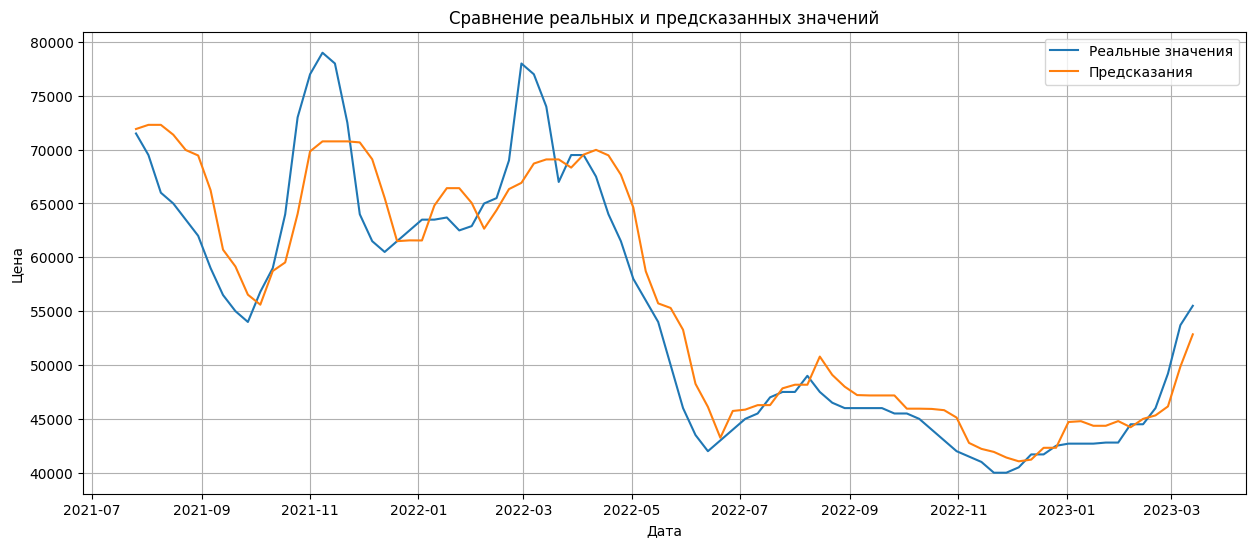

R² на обучении: 0.9861213833510537
R² на тесте: 0.883097934666383


['scaler1.pkl']

In [1]:
# Импорт необходимых библиотек
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# 1. Загрузка и объединение данных
train = pd.read_excel('train.xlsx', parse_dates=['dt'])
test = pd.read_excel('test.xlsx', parse_dates=['dt'])
full_data = pd.concat([train, test]).sort_values('dt').reset_index(drop=True)

# 2. Создание лагов и фичей на основе даты
# Логарифмирование для устранения асимметрии
full_data['log_price'] = np.log(full_data['Цена на арматуру'])

# Создание лагов (1, 2, 3, 7, 30 дней)
for lag in [1, 2]:
    full_data[f'lag_{lag}'] = full_data['log_price'].shift(lag)

# Создание временных фичей
full_data['month'] = full_data['dt'].dt.month
full_data['quarter'] = full_data['dt'].dt.quarter
full_data['year'] = full_data['dt'].dt.year

# Удаление пропусков после создания лагов
full_data = full_data.dropna()

# 2.5 Экспорт полного датасета с фичами для последующего использования в приложении
full_data[['dt', 'Цена на арматуру', 'log_price', 'lag_1', 'lag_2', 'month', 'quarter', 'year']].to_csv(
    'historical_data.csv', 
    index=False,
    encoding='utf-8-sig'  # для корректного отображения русских символов
)
# 3. Разделение на обучающую и тестовую выборки (без перемешивания)
X = full_data.drop(['Цена на арматуру', 'log_price', 'dt'], axis=1)
y = full_data['log_price']

# Выбор индексов для разделения
split_idx = int(len(X) * 0.8)
X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# 4. Обучение ансамбля моделей
# Random Forest с регуляризацией
rf = RandomForestRegressor(
    n_estimators=200,  # Уменьшить количество деревьев
    max_depth=3,       # Снизить глубину
    min_samples_leaf=5,  # Добавить регуляризацию
    random_state=42
)
rf.fit(X_train, y_train)

# CatBoost с обработкой категорий и регуляризацией
catboost = CatBoostRegressor(
    iterations=400,    # Уменьшить итерации
    depth=3,           # Снизить глубину
    learning_rate=0.05,  # Меньше скорость обучения
    l2_leaf_reg=5,     # Добавить L2-регуляризацию
    cat_features=['month', 'quarter', 'year'],
    silent=True
)

catboost.fit(X_train, y_train)

# Ансамблирование (среднее предсказаний)
y_pred_rf = rf.predict(X_test)
y_pred_cat = catboost.predict(X_test)
y_pred = (y_pred_rf + y_pred_cat) / 2

# Обратное преобразование из логарифма
y_test_exp = np.exp(y_test)
y_pred_exp = np.exp(y_pred)

# 5. Расчет метрик
print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp)}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))}")
print(f"R²: {r2_score(y_test_exp, y_pred_exp)}")

# 6. Построение графиков
plt.figure(figsize=(15, 6))
plt.plot(full_data['dt'].iloc[split_idx:], y_test_exp, label='Реальные значения')
plt.plot(full_data['dt'].iloc[split_idx:], y_pred_exp, label='Предсказания')
plt.title('Сравнение реальных и предсказанных значений')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.legend()
plt.grid()
plt.show()

# 7. Оценка на переобучение по R²
train_pred = np.exp((rf.predict(X_train) + catboost.predict(X_train)) / 2)
print(f"R² на обучении: {r2_score(np.exp(y_train), train_pred)}")
print(f"R² на тесте: {r2_score(y_test_exp, y_pred_exp)}")

# 8. Сохранение моделей в pickle-файл
import joblib

# Сохраняем обе модели и мета-информацию в словарь
model_artifact = {
    'rf_model': rf,
    'catboost_model': catboost,
    'features_order': X_train.columns.tolist(),  # сохраняем порядок фичей
    'log_transform_info': 'Цена преобразована через np.log()'  # мета-информация
}

# Экспорт в файл (лучше использовать joblib вместо pickle для больших моделей)
# Сохранение модели в scaler1.pkl
joblib.dump(model_artifact, 'scaler1.pkl')

In [2]:
# import pandas as pd
# import numpy as np
# from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# from sklearn.preprocessing import StandardScaler
# from sklearn.model_selection import TimeSeriesSplit
# import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')

# # Загрузка данных
# train = pd.read_excel('train.xlsx', sheet_name='Sheet1', parse_dates=['dt'])
# test = pd.read_excel('test.xlsx', sheet_name='Sheet1', parse_dates=['dt'])

# # Корректное объединение (без сортировки!)
# full_df = pd.concat([train, test], axis=0).reset_index(drop=True)

# # Создание расширенных временных признаков
# def create_features(df):
#     df = df.copy()
#     df['year'] = df['dt'].dt.year
#     df['month'] = df['dt'].dt.month
#     df['week'] = df['dt'].dt.isocalendar().week
#     df['day_of_week'] = df['dt'].dt.dayofweek
#     df['day_of_month'] = df['dt'].dt.day
#     df['is_month_start'] = df['dt'].dt.is_month_start.astype(int)
#     df['quarter'] = df['dt'].dt.quarter
#     df['rolling_7_mean'] = df['Цена на арматуру'].rolling(7).mean().shift(1)  # Исключаем текущее значение
#     return df

# full_df = create_features(full_df)

# # Создание лагов с защитой от утечки
# lags = [1, 7, 14, 21, 28]
# for lag in lags:
#     full_df[f'lag_{lag}'] = full_df['Цена на арматуру'].shift(lag)

# # Удаление пропусков после создания признаков
# full_df = full_df.dropna().reset_index(drop=True)

# # Разделение на трейн и тест по исходным границам
# test_size = len(test)
# train_part = full_df.iloc[:-test_size]
# test_part = full_df.iloc[-test_size:]

# # Подготовка данных
# features = [col for col in full_df.columns if col not in ['dt', 'Цена на арматуру']]
# X_train = train_part[features]
# y_train = train_part['Цена на арматуру']
# X_test = test_part[features]
# y_test = test_part['Цена на арматуру']

# # Масштабирование с учетом временного порядка
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.transform(X_test)

# # Настройка моделей с кросс-валидацией
# rf = RandomForestRegressor(
#     n_estimators=500,
#     max_depth=10,
#     min_samples_split=10,
#     random_state=42
# )

# gb = GradientBoostingRegressor(
#     n_estimators=400,
#     learning_rate=0.1,
#     max_depth=10,
#     random_state=42
# )

# # Стекинг-регрессор
# ensemble = StackingRegressor(
#     estimators=[
#         ('rf', rf),
#         ('gb', gb)
#     ],
#     final_estimator=GradientBoostingRegressor(n_estimators=50)
# )

# # Обучение
# ensemble.fit(X_train_scaled, y_train)
# preds = ensemble.predict(X_test_scaled)

# # Метрики
# print('=== Metrics ===')
# print(f'MAE: {mean_absolute_error(y_test, preds):.2f}')
# print(f'MSE: {mean_squared_error(y_test, preds):.2f}')
# print(f'RMSE: {np.sqrt(mean_squared_error(y_test, preds)):.2f}')
# print(f'R²: {r2_score(y_test, preds):.2f}')

# # Визуализация прогнозов
# plt.figure(figsize=(16, 8))
# plt.plot(test_part['dt'], y_test, label='Фактические значения', marker='o')
# plt.plot(test_part['dt'], preds, label='Прогноз', linestyle='--', marker='x')
# plt.title('Прогноз vs Факт (Только тестовые данные)')
# plt.xlabel('Дата')
# plt.ylabel('Цена на арматуру')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()
# ensemble.fit(X_train_scaled, y_train)

# # Предсказания на тренировочных и тестовых данных
# train_preds = ensemble.predict(X_train_scaled)
# test_preds = ensemble.predict(X_test_scaled)

# # Метрики для трейна и теста
# def print_metrics(y_true, preds, label):
#     print(f'\n{label}:')
#     print(f'MAE: {mean_absolute_error(y_true, preds):.2f}')
#     print(f'MSE: {mean_squared_error(y_true, preds):.2f}')
#     print(f'RMSE: {np.sqrt(mean_squared_error(y_true, preds)):.2f}')
#     print(f'R²: {r2_score(y_true, preds):.2f}')

# print('=== Train Metrics ===')
# print_metrics(y_train, train_preds, 'Train')

# print('\n=== Test Metrics ===')
# print_metrics(y_test, test_preds, 'Test')

# # Визуализация распределения ошибок
# plt.figure(figsize=(12, 6))
# plt.hist(y_train - train_preds, bins=30, alpha=0.5, label='Train Errors')
# plt.hist(y_test - test_preds, bins=30, alpha=0.5, label='Test Errors')
# plt.title('Распределение ошибок')
# plt.legend()
# plt.show()

# # Кросс-валидация с временным разделением
# tscv = TimeSeriesSplit(n_splits=5)
# cv_scores = []

# for train_index, val_index in tscv.split(X_train):
#     X_train_cv, X_val_cv = X_train_scaled[train_index], X_train_scaled[val_index]
#     y_train_cv, y_val_cv = y_train.iloc[train_index], y_train.iloc[val_index]
    
#     ensemble.fit(X_train_cv, y_train_cv)
#     val_preds = ensemble.predict(X_val_cv)
    
#     cv_scores.append(r2_score(y_val_cv, val_preds))

# print('\n=== Cross-Validation Scores ===')
# print(f'Средний R²: {np.mean(cv_scores):.2f}')
# print(f'Стандартное отклонение R²: {np.std(cv_scores):.2f}')
# print(f'Все оценки: {cv_scores}')

# # Визуализация прогнозов
# plt.figure(figsize=(16, 8))
# plt.plot(train_part['dt'], y_train, label='Фактические значения (Тренировка)', alpha=0.7)
# plt.plot(train_part['dt'], train_preds, label='Прогноз (Тренировка)', linestyle='--', alpha=0.7)
# plt.plot(test_part['dt'], y_test, label='Фактические значения (Тест)', marker='o')
# plt.plot(test_part['dt'], test_preds, label='Прогноз (Тест)', linestyle='--', marker='x')
# plt.title('Прогнозы на тренировочных и тестовых данных')
# plt.xlabel('Дата')
# plt.ylabel('Цена на арматуру')
# plt.legend()
# plt.grid(True)
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.show()

# # Метрики
# print("\n=== Метрики на тесте ===")
# print(f"MAE: {mean_absolute_error(y_test, test_preds):.2f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test, test_preds)):.2f}")
# print(f"R²: {r2_score(y_test, test_preds):.2f}")

# print("\n=== Проверка на переобучение ===")
# mae_train = mean_absolute_error(y_train, train_preds)
# mae_test = mean_absolute_error(y_test, test_preds)

# print(f"MAE на трейне: {mae_train:.2f}")
# print(f"MAE на тесте: {mae_test:.2f}")

# # Проверка на переобучение через разницу в MAE
# if mae_train < mae_test:
#     print("Модель может быть переобучена: MAE на трейне меньше MAE на тесте.")
# else:
#     print("Модель не переобучена: MAE на трейне не меньше MAE на тесте.")


In [3]:
# # Импорт библиотек
# import pandas as pd
# import numpy as np
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import matplotlib.pyplot as plt

# # 1. Объединение данных
# train = pd.read_excel('train.xlsx', parse_dates=['dt'])
# test = pd.read_excel('test.xlsx', parse_dates=['dt'])
# full_data = pd.concat([train, test]).sort_values('dt').reset_index(drop=True)

# # 2. Создание фичей и обработка нестационарности
# # Логарифмирование для устранения асимметрии
# full_data['log_price'] = np.log(full_data['Цена на арматуру'])

# # Лаги (1, 2, 3, 7 дней) для учета краткосрочной зависимости
# for lag in [1, 2, 3]:
#     full_data[f'lag_{lag}'] = full_data['log_price'].shift(lag)

# # Временные фичи для сезонности
# full_data['month'] = full_data['dt'].dt.month.astype(str)  # Категориальный признак
# full_data['day_of_week'] = full_data['dt'].dt.dayofweek
# full_data['is_month_start'] = full_data['dt'].dt.is_month_start.astype(int)

# # Дифференцирование (первая разница) для стационарности
# full_data['price_diff'] = full_data['Цена на арматуру'].diff()

# # Удаление пропусков
# full_data = full_data.dropna()

# # 3. Разделение данных с сохранением временного порядка
# split_idx = int(len(full_data) * 0.8)
# train_data = full_data.iloc[:split_idx]
# test_data = full_data.iloc[split_idx:]

# # Выбор фичей и целевой переменной
# features = ['month', 'day_of_week', 'is_month_start'] + [f'lag_{i}' for i in [1,2,3]]
# X_train, y_train = train_data[features], train_data['log_price']
# X_test, y_test = test_data[features], test_data['log_price']

# # 4. Обучение CatBoost с оптимизацией против переобучения
# model = CatBoostRegressor(
#     iterations=1000,
#     learning_rate=0.03,
#     depth=4,                   # Ограничение глубины деревьев
#     l2_leaf_reg=5,             # Регуляризация L2
#     early_stopping_rounds=50,  # Автоматическая остановка
#     cat_features=['month'],    # Указание категориальных признаков
#     verbose=100
# )

# model.fit(X_train, y_train, eval_set=(X_test, y_test))

# # 5. Расчет метрик
# y_pred = model.predict(X_test)
# y_test_exp = np.exp(y_test)          # Обратное преобразование из логарифма
# y_pred_exp = np.exp(y_pred)

# print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp):.0f}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test_exp, y_pred_exp)):.0f}")
# print(f"R²: {r2_score(y_test_exp, y_pred_exp):.3f}")

# # 6. Визуализация результатов
# plt.figure(figsize=(15, 6))
# plt.plot(test_data['dt'], y_test_exp, label='Реальные значения', alpha=0.7)
# plt.plot(test_data['dt'], y_pred_exp, label='Прогноз', linestyle='--')
# plt.title('Прогноз цен на арматуру')
# plt.xlabel('Дата')
# plt.ylabel('Цена')
# plt.legend()
# plt.grid(True)
# plt.show()

# # 7. Оценка переобучения
# train_pred = np.exp(model.predict(X_train))
# print(f"R² на обучении: {r2_score(np.exp(y_train), train_pred):.3f}")
# print(f"R² на тесте: {r2_score(y_test_exp, y_pred_exp):.3f}")

In [4]:
# # Создаем DataFrame с датами, реальными и предсказанными ценами
# results_df = pd.DataFrame({
#     'Date': test_data['dt'],               # Дата из тестового набора
#     'Real Price': y_test_exp,              # Реальные значения (после экспоненты)
#     'Predicted Price': y_pred_exp          # Предсказанные значения (после экспоненты)
# })

# # Сохраняем в CSV без индекса
# results_df.to_csv('new_predikt.csv', index=False, encoding='utf-8-sig')

In [5]:
# # Импорт необходимых библиотек
# import pandas as pd
# import numpy as np
# from sklearn.model_selection import train_test_split
# from sklearn.ensemble import RandomForestRegressor
# from catboost import CatBoostRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
# import matplotlib.pyplot as plt
# from statsmodels.tsa.seasonal import seasonal_decompose

# # 1. Загрузка и объединение данных
# train = pd.read_excel('train.xlsx', parse_dates=['dt'])
# test = pd.read_excel('test.xlsx', parse_dates=['dt'])
# full_data = pd.concat([train, test]).sort_values('dt').reset_index(drop=True)

# # 2. Создание лагов и фичей на основе даты
# # Логарифмирование для устранения асимметрии
# full_data['log_price'] = np.log(full_data['Цена на арматуру'])

# # Создание лагов (1, 2, 3, 7, 30 дней)
# for lag in [1, 2]:
#     full_data[f'lag_{lag}'] = full_data['log_price'].shift(lag)

# # Создание временных фичей
# full_data['month'] = full_data['dt'].dt.month
# full_data['quarter'] = full_data['dt'].dt.quarter
# full_data['year'] = full_data['dt'].dt.year

# # Удаление пропусков после создания лагов
# full_data = full_data.dropna()

# # 3. Разделение на обучающую и тестовую выборки (без перемешивания)
# X = full_data.drop(['Цена на арматуру', 'log_price', 'dt'], axis=1)
# y = full_data['log_price']

# # Выбор индексов для разделения
# split_idx = int(len(X) * 0.8)
# X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
# y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]

# # 4. Обучение ансамбля моделей
# # Random Forest с регуляризацией
# rf = RandomForestRegressor(
#     n_estimators=100,  # Уменьшить количество деревьев
#     max_depth=2,       # Снизить глубину
#     min_samples_leaf=5,  # Добавить регуляризацию
#     random_state=42
# )
# rf.fit(X_train, y_train)

# # CatBoost с обработкой категорий и регуляризацией
# catboost = CatBoostRegressor(
#     iterations=200,    # Уменьшить итерации
#     depth=2,           # Снизить глубину
#     learning_rate=0.02,  # Меньше скорость обучения
#     l2_leaf_reg=5,     # Добавить L2-регуляризацию
#     cat_features=['month', 'quarter', 'year'],
#     silent=True
# )

# catboost.fit(X_train, y_train)

# # Ансамблирование (среднее предсказаний)
# y_pred_rf = rf.predict(X_test)
# y_pred_cat = catboost.predict(X_test)
# y_pred = (y_pred_rf + y_pred_cat) / 2

# # Обратное преобразование из логарифма
# y_test_exp = np.exp(y_test)
# y_pred_exp = np.exp(y_pred)

# # 5. Расчет метрик
# print(f"MAE: {mean_absolute_error(y_test_exp, y_pred_exp)}")
# print(f"RMSE: {np.sqrt(mean_squared_error(y_test_exp, y_pred_exp))}")
# print(f"R²: {r2_score(y_test_exp, y_pred_exp)}")

# # 6. Построение графиков
# plt.figure(figsize=(15, 6))
# plt.plot(full_data['dt'].iloc[split_idx:], y_test_exp, label='Реальные значения')
# plt.plot(full_data['dt'].iloc[split_idx:], y_pred_exp, label='Предсказания')
# plt.title('Сравнение реальных и предсказанных значений')
# plt.xlabel('Дата')
# plt.ylabel('Цена')
# plt.legend()
# plt.grid()
# plt.show()

# # 7. Оценка на переобучение по R²
# train_pred = np.exp((rf.predict(X_train) + catboost.predict(X_train)) / 2)
# print(f"R² на обучении: {r2_score(np.exp(y_train), train_pred)}")
# print(f"R² на тесте: {r2_score(y_test_exp, y_pred_exp)}")